# Simple Machine-Learning: CNNs and Boosted Regression
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 6, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CNN_2D.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://ocean-satellite-tools.github.io/mind-the-chl-gap/_static/CNN_2D.ipynb
[colab-link]: https://colab.research.google.com/github/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CNN_2D.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/ocean-satellite-tools/mind-the-chl-gap/main/book/notebooks/CNN_2D.ipynb

>📘 Learning Objectives
>
> 1. Understand the basics of prediction
> 2. Learn the format that your data should be in
> 3. Learn to fit a CNN and Boosted Regression Tree
> 4. Evaluate fit
> 5. Make predictions with your model

::: {.callout-important}
# Important notes for this tutorial

### Data must be able to be loaded into memory

This notebook creates the training data as NumPy arrays. The data needs to be able to be loaded fully into memory. We will discuss working with larger than memory data in the advanced tutorials.

### Run this with GPU

This notebook is slow with CPU. You can run in Colab if you don't have GPU access. Click the "Open in Colab" button above. To get GPU in Colab, go to Edit > Notebook Settings  and select GPU. Then uncomment the `!pip` line below to install the needed libraries. For the JupyterHub, you might not have the option to select GPU.

### This notebook requires tensorflow

Colab has tensorflow installed by default. For the JupyterHub, you need to select an image with tensorflow. We used the image `quay.io/pangeo/ml-notebook:2025.05.22` for running the notebook. 

### The functions are in a separate file

The Python functions for doing tasks, like prepping the data and plotting, are in a separate file `ml_utils.py` and the functions are imported with `import ml_utils as mu`. You will need to run the import code to have access to the functions.
:::

## Summary

In this tutorial we will predict a variable (chl) using reponse variables, in this case SST, salinity, and season. 

$$
\hat{y} \sim f(sst, so, season, location)
$$

We will compare two classic machine-learning algorithms for prediction: 2-dimensional convolutional neural networks and boosted regression trees.

**How are they similar?**

Both are non-linear: they can learn complicated non-linear relationships like “very high CHL only occurs when SST is low and it’s winter and we are above a certain latitude threshold.” Both can handle complex interactions between variables (SST × salinity × season × location).  Both are strong baseline methods for prediction tasks like ours.

**How are they different?**

* Input shape: Boosted regression trees see individuals pixels. They ignore the neighboring pixels, unless we add them as extra predictor variables. 2D CNNs look at a small area around each pixel. They use the neighborhood to detect patterns like lines, blobs, and gradients.

* What they learn: Trees learn a big collection of if-else rules that split the response variable space. CNNs learn spatial filters (little square spatial weightings) that slide over the map to detect shapes and textures (e.g. sharp gradients).

* Spatial awareness: Trees have no built-in spatial structure; “location” is just another number. CNNs are explicitly designed for using spatial structure and patterns for the prediction.

* Interpretability: Trees (especially boosted trees with feature importance / partial dependence) are usually easier to interpret. CNNs are more of a black box; they can capture richer patterns but are harder to “read”.

## Overview of the modeling steps

1. Load data
2. Prepare training, test, and validation data. Normalize the training data and deal with NAs in the data.
3. Set up model
4. Fit model
5. Make predictions

## Variables in the model

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `sst`, `so`        | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `sin_time`, `cos_time` | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize** |
| `x_geo`,`y_geo`, `z_geo` | ✅ Varies by lat/lon   |❌ Static   | -1 to 1, **do not normalize**    |
| `ocean_mask`   | ✅ Varies by lat/lon     | ❌ Static           | Binary (0=land, 1=ocean), **do not normalize** |
| `cloud_mask`   | ✅ Varies by lat/lon     | ✅ Varies by time    | Binary (0=land, 1=ocean), **do not normalize** |
| `y` (log CHL) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, maybe normalize  |


- **`sst` and `so`**: These are our core predictor variables. We normalize these to mean 0 and s.d. of 1 so they are on the same scale.
  
- **`sin_time` and `cos_time`**: These introduce seasonality into our model. The models can learn seasonally dependent patterns, e.g., chlorophyll blooms in spring. The `sin_time` and `cos_time` features use cyclical encoding (sine/cosine). Normalizing these features (e.g., to mean 0, std 1) would distort their circular geometry and defeat their intended purpose.

- **`x_geo`, `y_geo`, and `z_geo`**: This is a dimensionless geometric encoding of location on the globe that is -1 to 1. This works better than lat/lon for machine-learning tasks. Including these location variables allows the model to learn location specific relationships.

- **`ocean_mask`, `cloud_mask`**: This tells the model which pixels are land (0) vs ocean (1) and cloud (0) versus valid (1). For the CNN, the mask is used in a custom loss function which helps avoid learning patterns over invalid/land/cloud areas. The ocean mask is also used as a predictor variable to help it learn the effect of coastlines.

- **`y` (response)**: The model trains on this. For our model it is logged CHL and it is roughly centered near 0. We need to evaluate whether our response has areas with much much higher variance than other areas. If so, we need to do some spatial normalization so our model doesn't only learn the high variance areas.

*Note, neither bathymetry nor distance from coast improved the model by any appreciable amount over the model we use here. SST (upwelling signal) and salinity (river outflow signal) are highly correlated with chlorophyll in this region with strong seasonal patterns. Including the ocean mask and location in the fitting allows it to learn the coastal patterns.* You can try distance to coast with:
```
ds = mu.add_distance_to_coast(ds, mask_var="ocean_mask", out_name="dist2coast_km")
```


## Dealing with NaNs

In our application, NaNs in y (in our case CHL) appear over land and when obscured by clouds. NaNs in our predictor variables are less common, but can happen.

Algorithms for boosted regression tree can filter out any pixels that have NaNs in the response and predictor variables so we just have to make sure that missing values, or areas to ignore like land are coded as NaN. 

But for CNNs dealing with NaNs is harder because the models do not allow any NaNs in the response or predictor variables. For `y`, the problem comes when the training algorithm calculates the training (and validation) loss. Those NaNs in `y` will lead to NaN in `y - y_pred`, the loss returns NaN and training immediately breaks down. We therefore use a custom masked loss function that multiplies the error by an ocean/valid-pixel mask and normalizes by the number of valid pixels, effectively excluding land/cloudy pixels from the loss and validation metrics.

NaNs/Infs in the predictor variables will prevent the model from creating a prediction at all. Therefore NaNs (or Infs) in our predictor variables must be replaced or imputed. In our example, we have some NaNs in SST and salinity. We replace these with the pixel median from the pixels that are not missing. In order to guard against training on too much imputed data, days with more than 5% missing pixels in the predictor variables are removed.


::: {.callout-note}
# Modifying the notebook to model your own data

You will need the following:

* Data: an xarray Dataset with your response variable and explanatory variables. 
* `num_var`: the variables which will be normalized
* `cat_var`: the variables which will be left as is
* `mask`: The model will not be trained on the data under the mask
* response variable (`y_var`) should have NaNs for missing values. Do not replace missing values with anything.
* functions: in `model_utils.py`
  
Variables can be 2D (not time-varying) or 3D (time-varying). They can be numerical (will be normalized) or categorical (will not be normalized). Note, categorical can be numerical. Difference is what will be normalized and what will not.
:::

## Load the libraries

In [3]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
# !pip install zarr gcsfs --quiet

In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

In [2]:
# --- TensorFlow libraries ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

In [3]:
# this requires that tensorflow and keras are available
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

# Prepare the Indian Ocean Dataset

This is a dataset for the Indian Ocean with a variety of variables, including a gap-free chlorophyll product from Copernicus.

### `open_dataset` versus `open_zarr`

The data in the Google Object Storage is a chunked Zarr file. It has files that are chunks of 100 days of data. When we go to get data we will get these files. How we load our data will determine if our xarray dataset "knows" about the chunks and this will make a big difference to speed and memory usage. 


In [4]:
# full dataset 1997 to 2022
# Note use open_zarr instead of open_dataset to preserve the chunking
data_full = xr.open_zarr(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr", 
    storage_options={"token": "anon"}, 
    consolidated=True
)
# slice to a smaller lat/lon segment
data_full = data_full.sel(lat=slice(35, -5), lon=slice(45,90))

# subset out predictors, response and land mask
pred_var = ["sst", "so"]
resp_var = "CHL_cmes-gapfree"
land_mask = "CHL_cmes-land"
dataset = data_full[pred_var + [resp_var, land_mask]]
dataset = dataset.rename({resp_var: "y", land_mask: "land_mask"})
# fix a chunking mis-match 
dataset = dataset.chunk({'time': 100, 'lat': 149, 'lon': 181})

# IMPORTANT: log our response so it is symmetric
dataset["y"] = np.log(dataset["y"])

# remove years with no response (y), sst or so data; these will be all NaN
vars_to_check = ["y", "so", "sst"]
drop = dataset[vars_to_check].to_array().isnull().all(["lat", "lon"]).any("variable")
dataset = dataset.sel(time=~drop)

# Make ocean mask
# Mark where SST (sea surface temperature) is always missing; these are likely lakes
dataset["land_mask"] = dataset["land_mask"] == 0 # make ocean 1 instead of land
invalid_ocean = np.isnan(dataset["sst"]).all(dim="time") 
dataset["land_mask"] = dataset["land_mask"].where(~invalid_ocean, other=False)
dataset = dataset.rename({"land_mask": "ocean_mask"})

# Add location and seasonal variables
dataset = mu.add_spherical_coords(dataset)  # add lat/lon variables to dataset
dataset = mu.add_seasonal_time_features(dataset)
dataset

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 8475, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 68kB 1997-10-01 1997-10-02 ... 2020-12-31
Data variables:
    sst         (time, lat, lon) float32 914MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    so          (time, lat, lon) float32 914MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    y           (time, lat, lon) float32 914MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    x_geo       (lat, lon) float32 108kB 0.5997 0.597 ... 0.004347 -4.355e-08
    y_geo       (lat, lon) float32 108kB 0.5997 0.6023 0.6049 ... 0.9962 0.9962
    z_geo       (lat, lon) float32 108kB 0.5299 0.5299 ... -0.08716 -0.08716
    sin_time    (time, lat, lon) float32 914MB -1.0 -1.0 -1.0 ... 0.0129 0.0129
    cos_time    (time, lat, lon) float32 914MB 0.001075 0.001075 ... 0.9999
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Process the data for training and testing

- Get the year(s) we want for training
- Remove the days with too many NaNs (> 10 percent) in response or explanatory variables
- Split data randomly into train, validate, and test pools
- Normalize the numerical predictor variables (SST and salinity)
- Replace NaNs in our numerical predictor variables with the pixel mean in training data.
- Return stacked Numpy arrays

We need to normalize (mean zero, variance of 1) our numerical predictor variables but we need to compute the normalization metrics (`X_mean` and `X_std`) from the training data only. Otherwise we would have "data leakage"; information from the data we are predicting (not using for training) is used in testing or validation.

This function is stored in `model_utils.py` and loaded with `import model_utils as mu`. If you are running this notebook in your own directory, you will need to download `model_utils.py` into the same directory as where you have this notebook.

In [26]:
help(mu.time_series_split)

Help on function time_series_split in module ml_utils:

time_series_split(data: xarray.core.dataset.Dataset, num_var, cat_var=None, mask='ocean_mask', split_ratio=(0.7, 0.2, 0.1), seed=42, X_mean=None, X_std=None, y_var='y', years=None, cast_float32=True, contiguous_splits=False, return_full=False, nan_max_frac_y=0.5, nan_max_frac_v=0.05, add_missingness=False, verbose=False)
    Pure-NumPy splitter/normalizer for xarray Dataset (NumPy-backed).
    Splits time indices randomly into train/val/test.
    Normalizes numerical variables only, using either provided or training-set mean/std.
    Replaces NaNs with 0s.
    Removes days with too many NaNs (>

    Parameters:
      data: xarray dataset with 'time' dimension
      years: year(s) to use for training
      num_var: list of numerical variable names (to normalize)
      cat_var: list of categorical variable names (no normalization)
      y_var: name of response variable in data.
      mask: name of the mask in the data. 0 = ignore; 1

In [5]:
# Our predictor variables; numerical variables and categorical variables
cnn_num_var = ['sst','so']
cnn_cat_var = ['ocean_mask','sin_time','cos_time','x_geo', 'y_geo', 'z_geo']
# Our time_series_split function needs the dataset to be loaded into memory
dataset.load();

In [6]:
# Train on 3 years in different decades
X, y, X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std = \
    mu.time_series_split(dataset, 
                         cnn_num_var, cat_var=cnn_cat_var, 
                         split_ratio=(0.7,0.2,0.1), 
                         years=[2000, 2010, 2020],
                         nan_max_frac_y=0.5,
                         nan_max_frac_v=0.05);

## Create the CNN model

A simple 3 layer 2D CNN to create pixel predictions.

In [7]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (lat, lon, number of variables)=(149, 181, 2)

    Returns
    -------
    model : keras.Model
        predicts a single-channel target (e.g., log-CHL) per pixel.
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — widen receptive field with a single 5×5; The effective receptive field is ~11×11.
    # Skip BN/Dropout here to keep features stable into the linear head; 
    # Earlier blocks already handle regularization.
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))

    # Output
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = 1 filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

## Create a custom loss function

The y have NaNs (over land and under clouds). We need to mask these out to calculate the training and validation loss. That way we do not train on NAs in y.

In [8]:
import tensorflow as tf
import numpy as np

# Build once, BEFORE compiling the model
floatx = tf.keras.backend.floatx()  # e.g., 'float32' or 'float16' if using mixed precision
ocean_mask_np = dataset['ocean_mask'].values.astype(np.float32)           # (H, W)
OCEAN_MASK = tf.constant(ocean_mask_np)[tf.newaxis, ..., tf.newaxis]      # (1, H, W, 1)
ocean_bool = tf.greater(OCEAN_MASK, 0.5)

@tf.function
def masked_mae(y_true, y_pred):
    # Ensure shape (B, H, W, 1)
    if y_true.shape.rank == 3:
        y_true = y_true[..., tf.newaxis]
    if y_pred.shape.rank == 3:
        y_pred = y_pred[..., tf.newaxis]

    # Valid where labels are finite (not = NaN)
    valid = tf.math.is_finite(y_true)   # (B, H, W, 1), bool
    mask_bool = tf.logical_and(valid, ocean_bool)
    mask = tf.cast(mask_bool, y_true.dtype)
    mask = tf.stop_gradient(mask)

    # Safe labels for diff (avoid any NaNs in subtraction)
    y_true_safe = tf.where(mask_bool, y_true, tf.zeros_like(y_true))

    diff = tf.abs(y_true_safe - y_pred) * mask
    denom = tf.reduce_sum(mask) + tf.keras.backend.epsilon()
    # Safe divide: if a batch has no valid ocean pixels, return 0.0 instead of NaN.
    return tf.where(denom > 0, tf.reduce_sum(diff) / denom, tf.zeros((), y_true.dtype))

## Build the model

First let's look at the input shape of our data. We are passing in the whole region.

In [77]:
X_train.shape

(765, 149, 181, 8)

In [9]:
# Create the model using the correct input shape
model = create_model_CNN(X_train.shape[1:])

# Check the model summary
# model.summary()

## Train the model

In [10]:
# Compile the model with Adam optimizer and mean absolute error (MAE) as both loss and evaluation metric
model.compile(
    optimizer='adam',    # Efficient and widely used optimizer
    loss=masked_mae,          # Mean Absolute Error: good for continuous data like CHL
    metrics=[masked_mae]      # Also track MAE during training/validation
)

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)  # Shuffle the data (helps generalization)
train_dataset = train_dataset.batch(8)                   # Batch size = 8

# Create a TensorFlow dataset for validation (no shuffle)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 0.5784 - masked_mae: 0.5783 - val_loss: 0.7835 - val_masked_mae: 0.7806
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3215 - masked_mae: 0.3215 - val_loss: 0.4698 - val_masked_mae: 0.4663
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3016 - masked_mae: 0.3016 - val_loss: 0.3573 - val_masked_mae: 0.3545
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2857 - masked_mae: 0.2857 - val_loss: 0.2925 - val_masked_mae: 0.2910
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2715 - masked_mae: 0.2715 - val_loss: 0.2798 - val_masked_mae: 0.2788
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2696 - masked_mae: 0.2696 - val_loss: 0.2616 - val_masked_mae: 0.2607
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2680 - masked_mae: 0.2680 - val_loss: 0.2599 - val_masked_mae: 0.2603
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2650 - masked_mae: 0.

### Save the model for loading later

In [11]:
# Save
meta = {"num_var": cnn_num_var, "cat_var": cnn_cat_var, "input_shape": list(X_train.shape[1:])}
mu.save_cnn_bundle("artifacts/cnn_bundle.zip", model, X_mean, X_std, meta)


'artifacts/cnn_bundle.zip'

In [10]:
# Load later (in a fresh session)
from model_utils import load_cnn_bundle
model, X_mean, X_std, meta = load_cnn_bundle("artifacts/cnn_bundle.zip", compile=False)


## Plot training & validation loss values

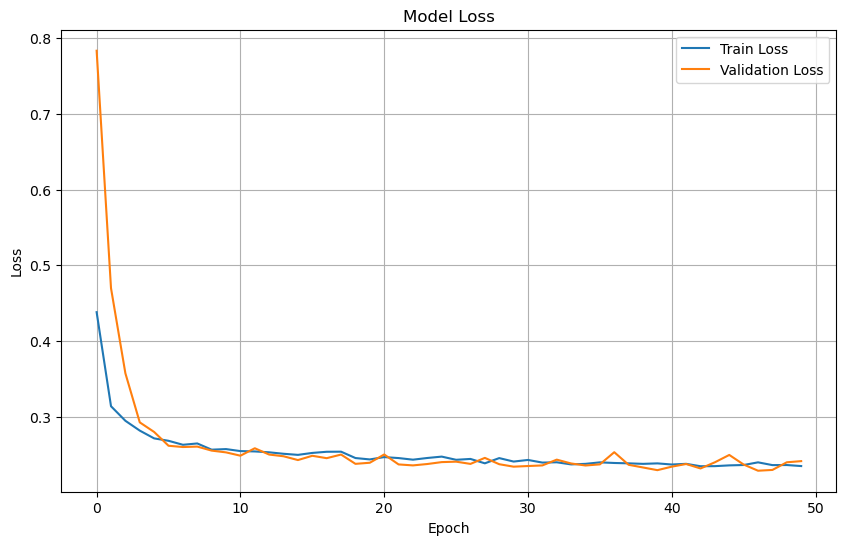

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [40]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1185 - masked_mae: 0.1184
Test Loss: 0.12021403759717941
Test MAE: 0.11952219158411026


## Make some maps of our predictions

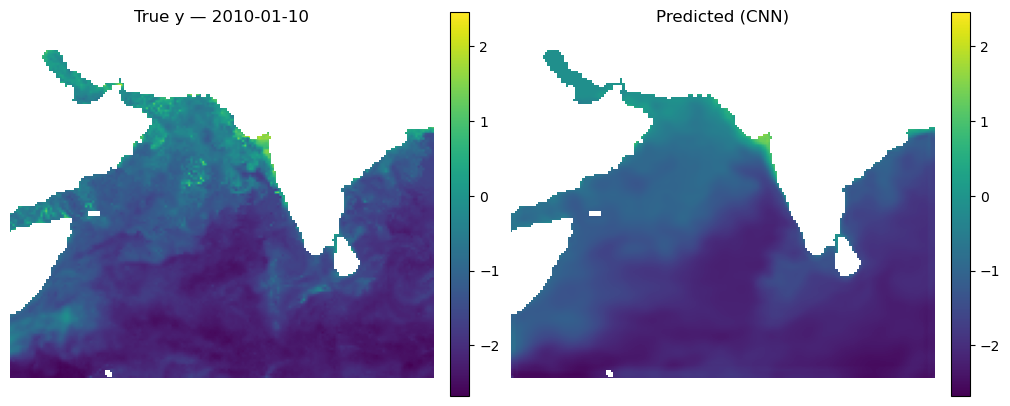

In [13]:
_ = mu.predict_and_plot_date(
    data_xr=dataset,
    date="2010-01-10",
    model=model,
    num_var=cnn_num_var,
    cat_var=cnn_cat_var,
    X_mean=X_mean, X_std=X_std,
    model_type="cnn",
    use_percentiles=False
)

### Let's look at all the months

This is a function that takes our model, the normalizing `X_mean` and `X_std`, the year to use and then makes plots of true versus predicted for the first available day each month. We need to use `X_mean` and `X_std` from our training data. This was returned by `time_series_split()` above. 

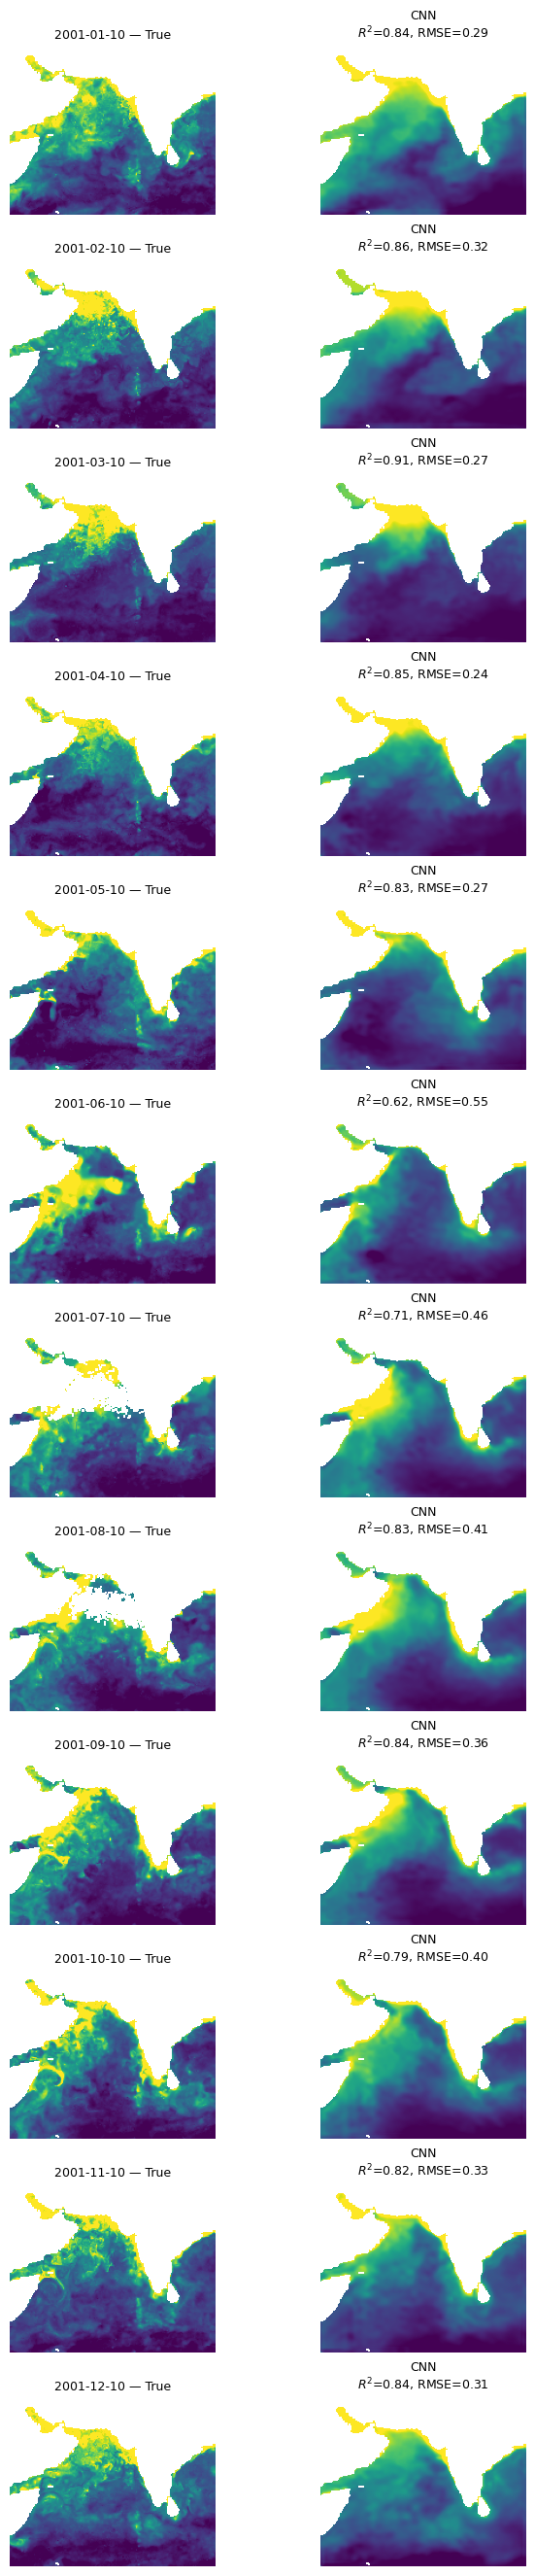

In [14]:
mu.plot_true_vs_predicted_year_multi(
    dataset, "2001", [model], X_mean, X_std, 
    cnn_num_var, cnn_cat_var, y_var="y", day=10,
    model_types=["cnn"],
    model_names=["CNN"])

## Look at fit metrics over years

Here I compute the metrics for 4 days in each month and average together. The metrics are R2, bias, mean abs error and SSIM. SSIM/MS-SSIM is a metric for images. It runs from (about) 0 to 1. Higher is better; 1.0 = identical. Rough, practical bands:

* ≥ 0.95 — near-indistinguishable (often called “visually lossless” in imaging)
* 0.90–0.95 — very good structural agreement
* 0.80–0.90 — clearly similar patterns, some blur/offset/contrast differences
* 0.60–0.80 — moderate; big structures align but details differ
* < 0.60 — poor structural match

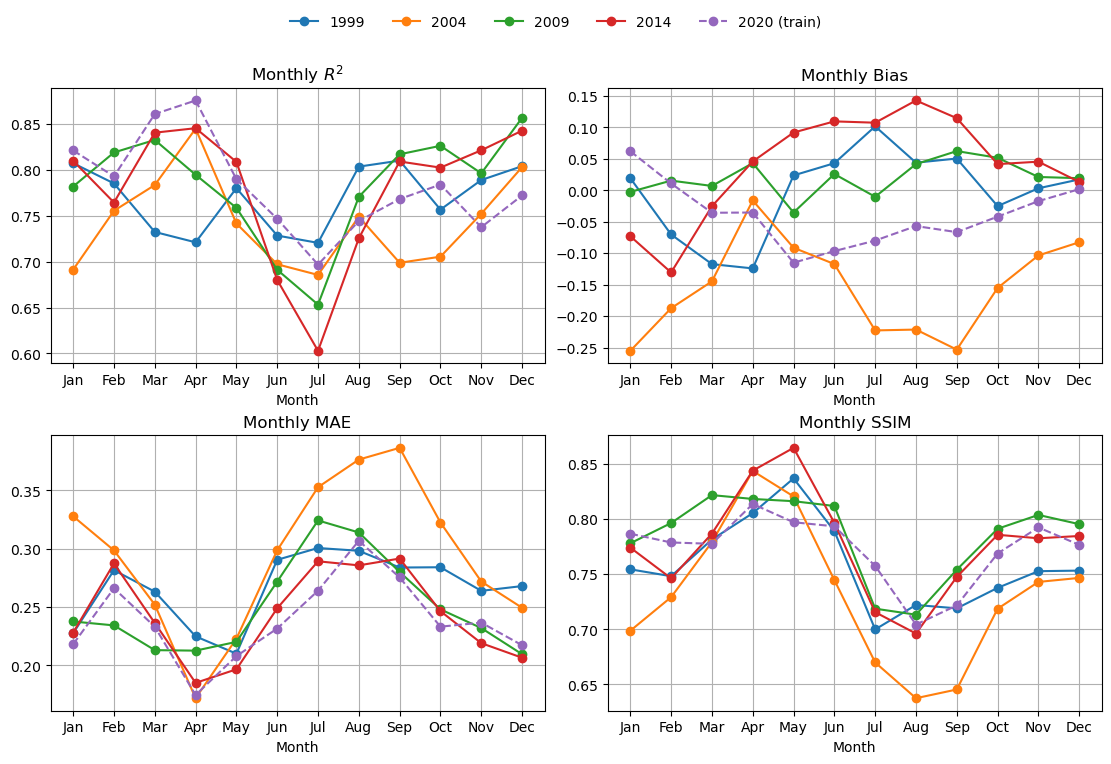

CPU times: user 9 s, sys: 107 ms, total: 9.1 s
Wall time: 9.09 s


In [15]:
%%time
mu.plot_4metric_by_month(dataset, ['1999', '2004', '2009', '2014', '2020'], 
                     model, X_mean, X_std, 
                     cnn_num_var, cnn_cat_var,
                     training_year="2020")

## Compare to a BRT

We will use exactly the same explanatory variables. The main difference is that the BRT does not learn local features, like fronts and edges. On the otherhand, it doesn't have the CNNs tendency to smudge out (average) local patterns.

In [16]:
# Fit the model
brt, brt_model = mu.train_brt_from_splits(
    X_train, y_train, feature_names=cnn_num_var + cnn_cat_var,
    grid_shape=(dataset.sizes['lat'], dataset.sizes['lon'])
)

## Look a fit metrics

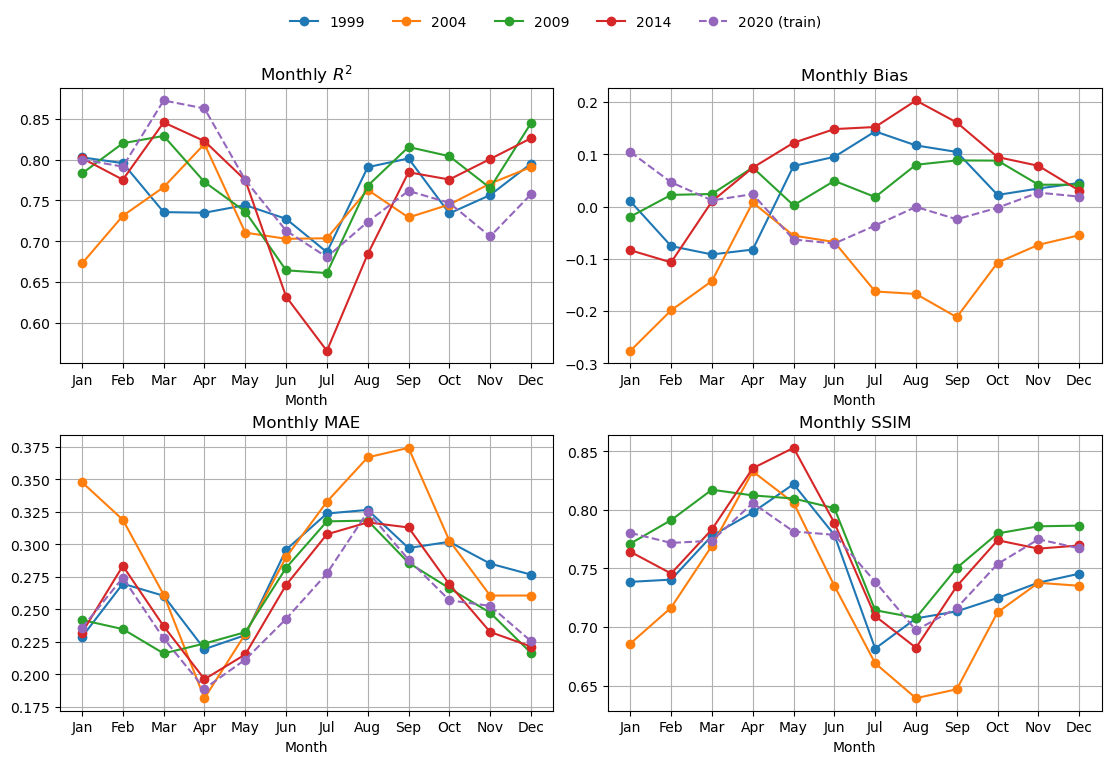

CPU times: user 2min 20s, sys: 175 ms, total: 2min 20s
Wall time: 1min 12s


In [17]:
%%time
mu.plot_4metric_by_month(dataset, ['1999', '2004', '2009', '2014', '2020'], 
                     brt_model, X_mean, X_std, 
                     cnn_num_var, cnn_cat_var,
                     training_year="2020",
                     model_type="brt")

## Make some plots

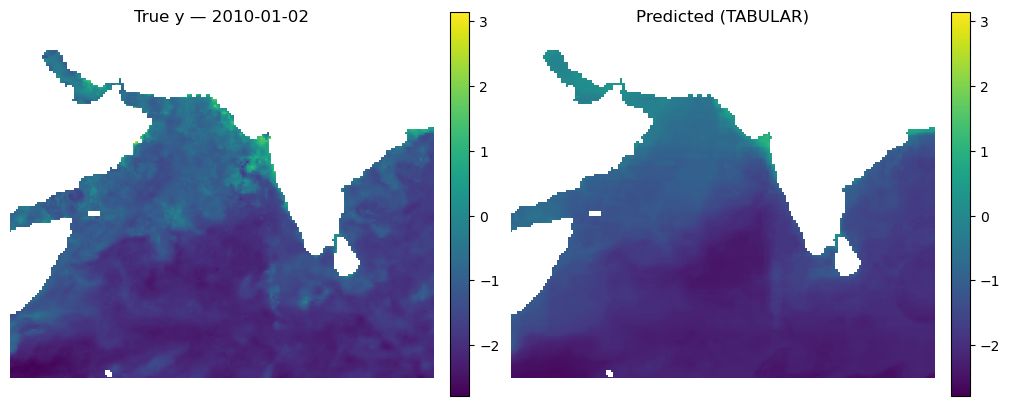

In [18]:
_ = mu.predict_and_plot_date(
    data_xr=dataset,
    date="2010-01-02",
    model=brt_model,
    num_var=cnn_num_var,
    cat_var=cnn_cat_var,
    X_mean=X_mean, X_std=X_std,
    model_type="tabular",
    use_percentiles=False
)

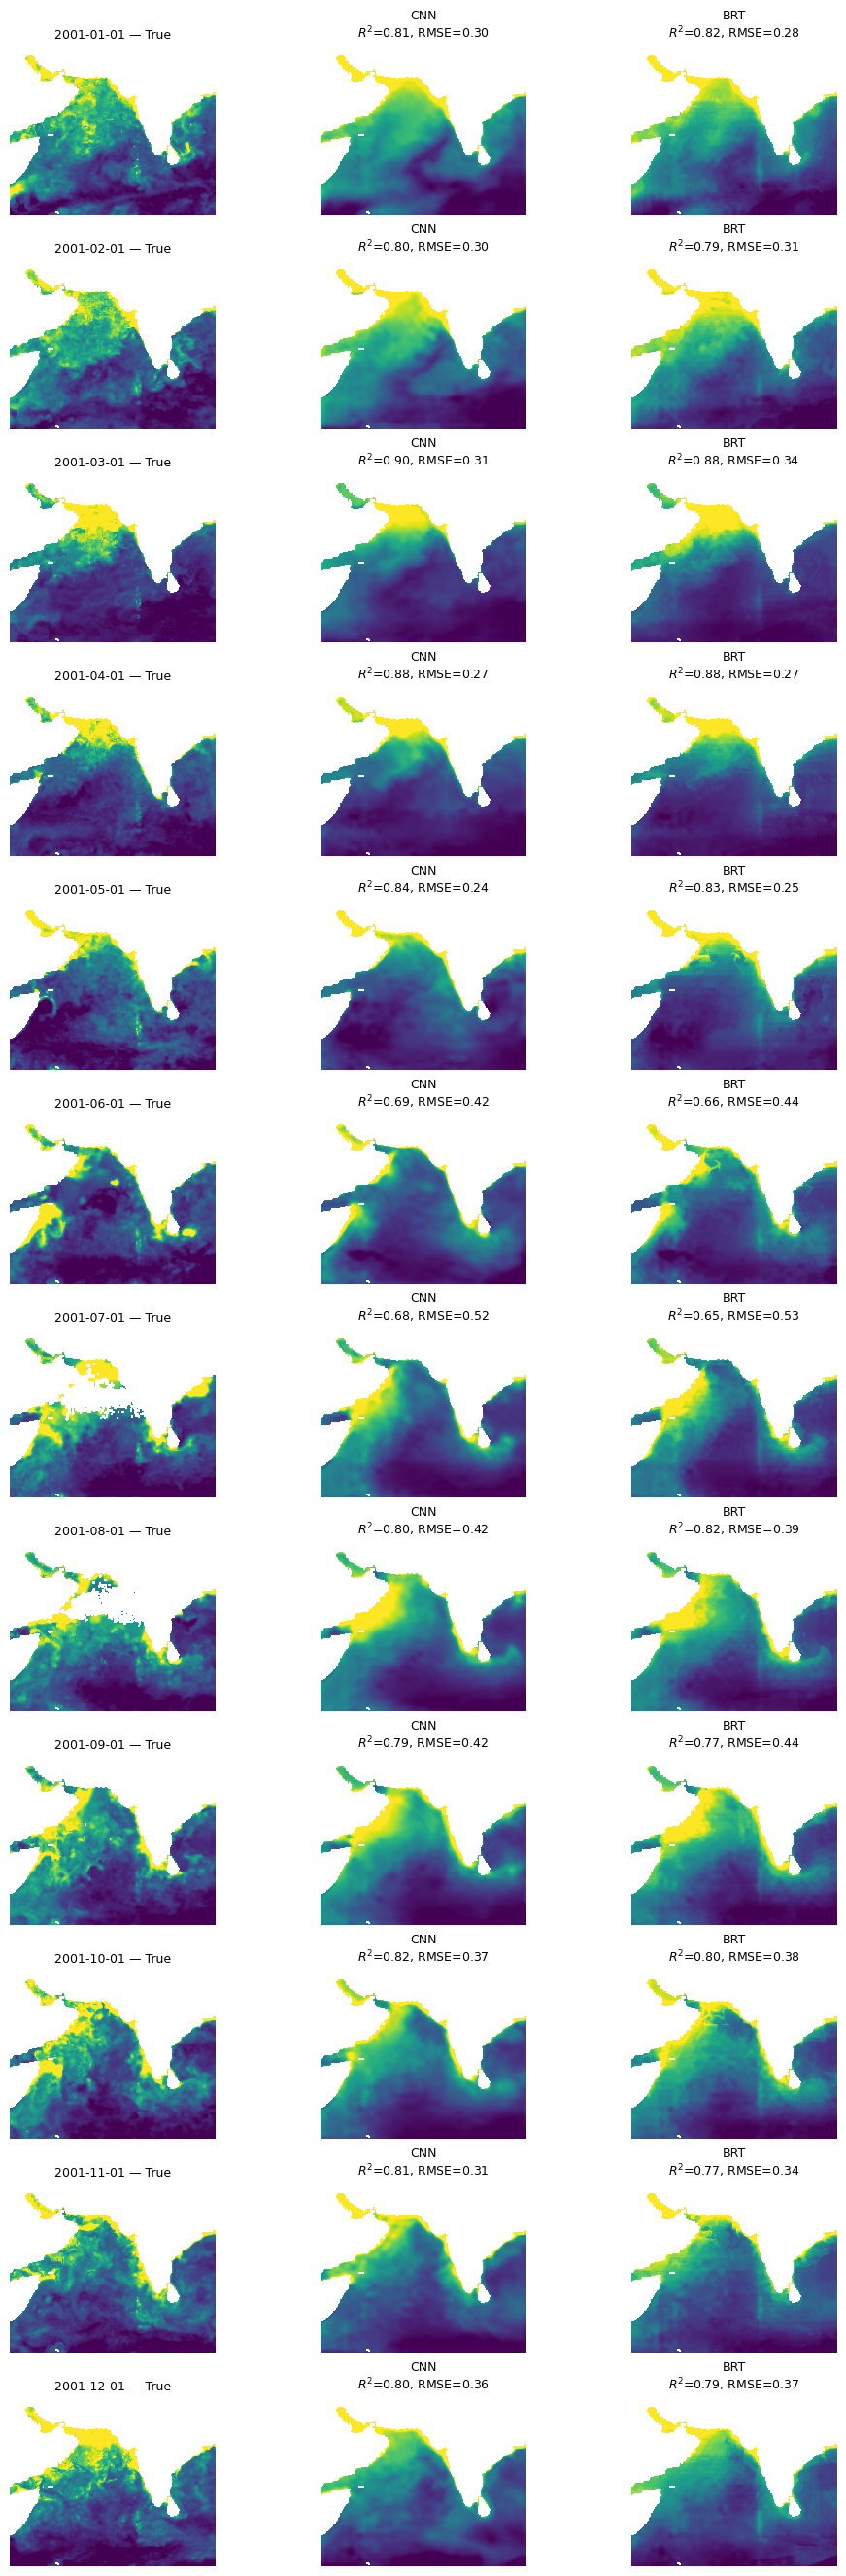

In [19]:
mu.plot_true_vs_predicted_year_multi(
    dataset, "2001", [model, brt_model], X_mean, X_std, 
    cnn_num_var, cnn_cat_var, y_var="y",
    model_types=["cnn", "tabular"],
    model_names=["CNN", "BRT"])

## Summary

Now we have a model that is doing ok. It still doesn't pick up the upwelling zone at the southern tip of India too well however. There is something about that area that is different and that the model is unable to learn. We should look into what drives that upwelling zone. It maybe that the relationship between SST and salinity are different there. It pokes down into a strong E-W current system.

Also the out of training years shows big variation in performance by season which suggests that we need to train on more years (more seasons).

We used the full region as the input shape for learning. What might have happened is that the model learned where and when in the region CHL tends to be high and low. But it might not have used SST and salinity at all and it might, therefore, have a hard time generalizing to other years. Note it is unlikely that this model would generalize to other regions as the SST and salinity associations are very specific to the oceanography and ocean biochemistry of the region.  

## Functions

Save to `utils.py` and load.

In [80]:
import numpy as np
import pandas as pd
import xarray as xr

def count_valid_days_by_month(
    ds: xr.Dataset,
    year,
    vars_to_check=("y",),          # str or iterable of str
    mask_var="ocean_mask",         # 1=ocean, 0=land
    nan_max_frac=0.05,             # allow ≤ 5% NaNs over ocean
):
    """
    Return a Series with counts of days per month that pass the NaN filter.
    A day passes iff, for every variable in `vars_to_check`, the number of
    NaNs over the ocean is <= nan_max_frac * ocean_pixels_on_that_day.
    """
    # subset to the year
    dsy = ds.sel(time=str(year))

    # tidy inputs
    if isinstance(vars_to_check, str):
        vars_to_check = [vars_to_check]

    # spatial mask, broadcast to (time, lat, lon)
    ocean = dsy[mask_var].astype(bool)
    if "time" not in ocean.dims:
        ocean = ocean.expand_dims(time=dsy["time"])
    # broadcast to the target grid (uses first var as template)
    template = dsy[vars_to_check[0]] if vars_to_check else dsy["y"]
    ocean = ocean.broadcast_like(template)

    # how many ocean pixels each day?
    spatial_dims = [d for d in ocean.dims if d != "time"]
    ocean_count = ocean.sum(dim=spatial_dims)  # (time,)
    nan_thresh_t = nan_max_frac * ocean_count  # per time-step threshold

    # build per-var validity (True if NaN count over ocean <= threshold)
    valid_per_var = []
    for v in vars_to_check:
        if v not in dsy:
            raise KeyError(f"Variable '{v}' not in dataset.")
        arr = dsy[v]
        if "time" not in arr.dims:
            arr = arr.expand_dims(time=dsy["time"])
        arr = arr.broadcast_like(ocean)
        v_nan = xr.apply_ufunc(np.isnan, arr) & ocean
        v_nan_count = v_nan.sum(dim=spatial_dims)  # (time,)
        valid_per_var.append(v_nan_count <= nan_thresh_t)

    # day is valid if all vars pass
    valid_all = xr.concat(valid_per_var, dim="var").all(dim="var")  # (time,) bool

    # group by month and count
    month_idx = pd.to_datetime(valid_all["time"].values).month
    counts = pd.Series(valid_all.values, index=month_idx).groupby(level=0).sum().astype(int)
    # ensure all months present
    counts = counts.reindex(range(1,13), fill_value=0)
    counts.index.name = "month"
    counts.name = f"valid_days_{year}"
    return counts


In [89]:
# Count days per month in 2020 where y has ≤5% NaNs over ocean
c1 = count_valid_days_by_month(dataset, 2010, vars_to_check="y", nan_max_frac=0.08)
print(c1)

month
1     31
2     28
3     31
4     30
5     31
6     30
7     12
8     29
9     30
10    31
11    30
12    31
Name: valid_days_2010, dtype: int64


In [52]:
X_val.shape

(219, 149, 181, 8)

In [19]:
%%time
# CNN example
daily, monthly = mu.evaluate_year_batched(
    dataset, 2014, model, X_mean, X_std,
    num_var=cnn_num_var, cat_var=cnn_cat_var,
    model_type='cnn', batch_size=16
)

CPU times: user 36.1 s, sys: 5.34 s, total: 41.4 s
Wall time: 50 s


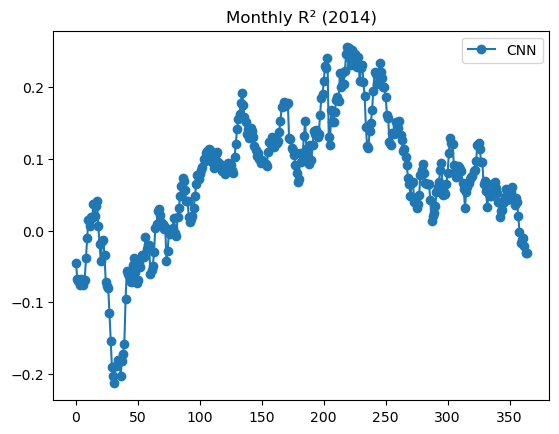

In [23]:

# Plot monthly R2, etc.
daily['bias'].plot(marker='o', label='CNN'); 
plt.legend(); plt.title("Monthly R² (2014)"); plt.show()